In [20]:
import numpy as np
import scipy.stats
import h5py
import sys
import pickle
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats
%matplotlib inline
sys.path.insert(0,"../")
import illustris_python as il

In [13]:
import requests
from io import BytesIO

headers = {"api-key":"109e327dfdd77de692d65c833f0a9483"}

def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    return r

In [14]:
from astropy.cosmology import FlatLambdaCDM

datared1=np.genfromtxt('data/redshift_TNG', dtype=[('snap','<i8'), ('redshift','<f8')])

def find_redshift(snap):
    arg=np.where(datared1['snap']==snap)[0]
    if len(arg)>0:
        return datared1['redshift'][arg[0]]

def redshift(scale):
    return 1.0/scale - 1.0

cosmo = FlatLambdaCDM(H0=70.4, Om0=0.2726)

def age(redshift):
    age1=cosmo.age(redshift)
    return 13.7 - age1.value

In [15]:
basePath = '/home/rdsouza/SIMS/TNG50/output/'

In [16]:
def find_rotation_angle(vector,vector0):
    vector=vector/np.linalg.norm(vector)
    vector0=vector0/np.linalg.norm(vector0)
    dotproduct=np.dot(vector,vector0)
    return np.fabs(dotproduct)

#return x,y,mu_x,mu_y for a certain projection
def get_xymu(iproj,xyz2,galaxy_pos):
    if iproj==0:
        x=xyz2[:,0]
        y=xyz2[:,1]
        mu_x=galaxy_pos[0]
        mu_y=galaxy_pos[1]
    elif iproj==1:
        x=xyz2[:,0]
        y=xyz2[:,2]
        mu_x=galaxy_pos[0]
        mu_y=galaxy_pos[2]
    elif iproj==2:
        x=xyz2[:,1]
        y=xyz2[:,2]
        mu_x=galaxy_pos[1]
        mu_y=galaxy_pos[2]
    else:
        assert(True==False)     #wrong iproj value
    return x,y,mu_x,mu_y

def get_pos(coordinates):
    center=np.median(coordinates,axis=0)
    return center



def return_tensor(dm,masssel):
    tensor = np.zeros([3,3])
    rn= dm[:,0]**2 + dm[:,1]**2 + dm[:,2]**2 
    tensor[0,0] = np.sum((dm[:,1]*dm[:,1] + dm[:,2]*dm[:,2]) * masssel[:]/rn)
    tensor[1,1] = np.sum((dm[:,0]*dm[:,0] + dm[:,2]*dm[:,2]) * masssel[:]/rn)
    tensor[2,2] = np.sum((dm[:,0]*dm[:,0] + dm[:,1]*dm[:,1]) * masssel[:]/rn)
    tensor[0,1] = - np.sum(dm[:,0] * dm[:,1] * masssel[:]/rn)
    tensor[1,0] = tensor[0,1]
    tensor[0,2] = - np.sum(dm[:,0] * dm[:,2] * masssel[:]/rn)
    tensor[2,0] = tensor[0,2]
    tensor[1,2] = - np.sum(dm[:,1] * dm[:,2] * masssel[:]/rn)
    tensor[2,1] = tensor[1,2]
    return tensor



def find_eigenvectors(dm, masssel):
    tensor=return_tensor(dm,masssel)
    w,v=np.linalg.eig(tensor)
    indices = np.argsort(w)[::-1]
    w = w[indices]
    v = v.T[indices]
    return w, v

def find_eigenvectors_array(dm, masssel):
    ll=len(masssel)
    wlist=[]
    vlist=[]
    for i in range(100):
        mask=np.random.randint(ll,size=ll)
        tensor=return_tensor(dm[mask],masssel[mask])
        w,v=np.linalg.eig(tensor)
        indices = np.argsort(w)[::-1]
        w = w[indices]
        v = v.T[indices]

        wlist.append(w)
        vlist.append(v)
    wlist=np.array(wlist)
    vlist=np.array(vlist)
    return np.mean(wlist,axis=0), np.std(wlist,axis=0), np.mean(vlist,axis=0), np.std(vlist,axis=0)





In [17]:
h0=0.6774
G0=4.3e-6   

In [18]:
from findtags import create_tags

In [9]:
# choose a subhalo which is very disk like.
subfindID0=521803

In [10]:
# separate the stellar particles into 3 sections:
# main progenitor - a1
# born inside the halo group but not in the main progentior
# born outside the halo
a1,a2,a3=create_tags(subfindID0,basePath)

In [11]:
print(len(np.where(a1)[0]),len(np.where(a2)[0]),len(np.where(a3)[0]))

682949 21070 21083


In [16]:
# If one is using the jupyter-notebook online on the TNG server do.....

#fields1=['Coordinates','Velocities','ParticleIDs']
#data1=il.snapshot.loadSubhalo(basePath,99,subfindID0,1,fields=fields1)
#fields2=['Coordinates','Velocities','Masses','ParticleIDs']
#data4=il.snapshot.loadSubhalo(basePath,99,subfindID0,4,fields=fields2)

In [21]:
# Otherwise download the cutof the file.


fname='cutout_521803.hdf5'
if os.path.isfile(fname):
    pass
else:
    sub_prog_url = "http://www.tng-project.org/api/TNG50-1/snapshots/%d/subhalos/%d/"%(99,subfindID0)
    cutout_request = {'dm':'all','stars':'all'}
    cutout = get(sub_prog_url+"cutout.hdf5", cutout_request)
    bytesio_object = BytesIO(cutout.content)
    with open(fname, "wb") as f:
        f.write(bytesio_object.getbuffer())



In [22]:
# Read some of the data
h1=h5py.File(fname,'r')
data1=h1['PartType1']
data4=h1['PartType4']

coordinates_dm= data1['Coordinates'][:]/h0
velocities_dm=data1['Velocities'][:]
id_dm=data1['ParticleIDs'][:]
dm_mass=np.ones(coordinates_dm.shape[0])*3.07367708626464e05/h0

coordinates= data4['Coordinates'][:]/h0
velocities=data4['Velocities'][:]
masses=data4['Masses'][:]*1e10/h0
ids= data4['ParticleIDs'][:]


# calculate in a simple dirty way, the center
gal_pos1=np.median(coordinates,axis=0)
gal_vel1=np.median(velocities,axis=0)
coordinates=coordinates-gal_pos1
coordinates_dm=coordinates_dm-gal_pos1

velocities=velocities-gal_vel1
velocities_dm=velocities_dm-gal_vel1

# Find the eigenvectors of the moment of inertia tensor, but restrict it to 30 kpc.
radmax=np.sqrt(np.sum(coordinates*coordinates,axis=1))
mask1 = (radmax > 0) & (radmax < 30)
w,v0=find_eigenvectors(coordinates[mask1],masses[mask1])


coordinates_rot=np.zeros_like(coordinates)
velocities_rot=np.zeros_like(velocities)
coordinates_dm_rot=np.zeros_like(coordinates_dm)
velocities_dm_rot=np.zeros_like(velocities_dm)
for j in range(len(coordinates)):
    coordinates_rot[j,:]=np.inner(coordinates[j,:],v0)
    velocities_rot[j,:]=np.inner(velocities[j,:],v0)
for j in range(len(coordinates_dm)):
    coordinates_dm_rot[j,:]=np.inner(coordinates_dm[j,:],v0)
    velocities_dm_rot[j,:]=np.inner(velocities_dm[j,:],v0)
    

In [23]:
coordinates_rot

array([[-1.04427226e-02, -4.28631735e-02,  2.65444834e-02],
       [ 1.07829070e-02, -3.12331279e-02, -3.37453882e-02],
       [-3.07004164e-02,  7.32606128e-02,  7.88553844e-02],
       ...,
       [ 2.62756390e+02, -2.50557396e+02, -3.49949679e+02],
       [ 2.12563920e+02, -3.28910970e+02, -5.21874409e+02],
       [ 2.88279522e+02, -3.47791073e+02, -3.17238872e+02]])

In [24]:
np.sum(masses[a1])+np.sum(masses[a2])+np.sum(masses[a3]),np.sum(masses)

(43587875000.0, 43652825000.0)

In [25]:
np.sum(masses[~a1])/np.sum(masses)

0.055943362

In [26]:
# Remember that 0 will be the shortest axis as that has the maximum moment of inertia tensor.

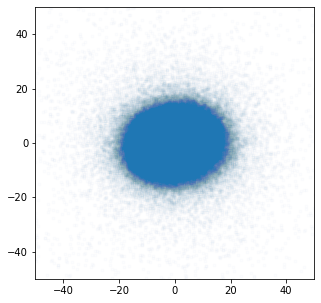

In [27]:
# The original projection
plt.figure(figsize=(5,5))
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.plot(coordinates[:,1],coordinates[:,0],'.', alpha=0.01)

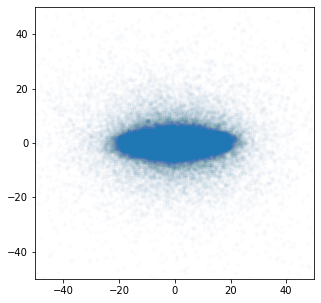

In [28]:
# The new projection
plt.figure(figsize=(5,5))
plt.xlim(-50,50)
plt.ylim(-50,50)
plt.plot(coordinates_rot[:,1],coordinates_rot[:,0],'.', alpha=0.01)

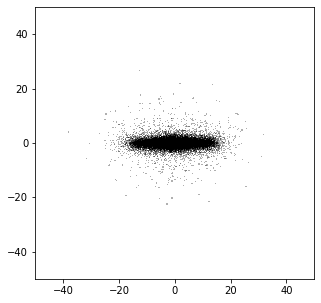

In [29]:
# Lets plot this better to imitate a galaxy image.
# First we make a 2D plot with very small bins.
# Second, we calcualate a 2D histogam.
# Then we make the following assumptions  a) that our eye is sensitive to light which scales as the log of the flux, 
# b) the flux is proportianal to the mass.

import matplotlib.colors as colors
plt.figure(figsize=(5,5))
plt.xlim(-50,50)
plt.ylim(-50,50)
bins=np.arange(-50,50,0.11)
tmp=plt.hist2d(coordinates_rot[:,1],coordinates_rot[:,0],[bins,bins],cmap='binary',norm=colors.LogNorm(vmin=1,vmax=9))

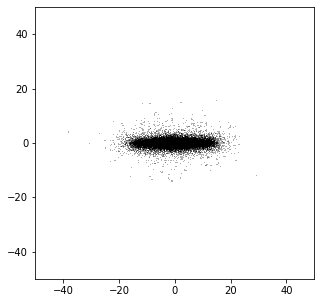

In [34]:
# Plot only insitu stars
import matplotlib.colors as colors
plt.figure(figsize=(5,5))
plt.xlim(-50,50)
plt.ylim(-50,50)
bins=np.arange(-50,50,0.11)
tmp=plt.hist2d(coordinates_rot[a1,1],coordinates_rot[a1,0],[bins,bins],cmap='binary',norm=colors.LogNorm(vmin=1,vmax=9))

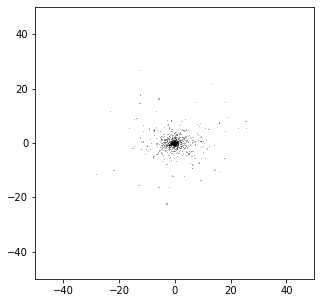

In [33]:
# Plot only accreted stars
import matplotlib.colors as colors
plt.figure(figsize=(5,5))
plt.xlim(-50,50)
plt.ylim(-50,50)
bins=np.arange(-50,50,0.11)
tmp=plt.hist2d(coordinates_rot[a3,1],coordinates_rot[a3,0],[bins,bins],cmap='binary',norm=colors.LogNorm(vmin=1,vmax=9))